In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats
import scipy.special

In [2]:
x = np.fromfile('ed4yae_10GHz.c64', dtype = 'complex64')

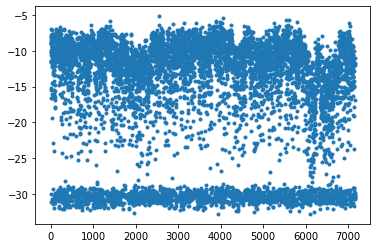

In [3]:
avg = 100
x_pwr_avg = np.sum(np.abs(x[:x.size//100*100].reshape((-1,100)))**2, axis = 1)
plt.plot(10*np.log10(x_pwr_avg), '.')

In [4]:
tone = 10*np.log10(x_pwr_avg) > -25
windows = list()
in_tone = False
for j, t in enumerate(tone):
    if not in_tone and t:
        left = j
        in_tone = True
    elif in_tone and not t:
        windows.append((left, j))
        in_tone = False
tone_windows = [w for w in windows if w[1] - w[0] > 50]

In [5]:
def estimate_rice(x):
    r = np.average(x) / np.std(x)
    theta = 1
    for iteration in range(100):
        I0 = scipy.special.iv(0, theta**2/4)
        I1 = scipy.special.iv(1, theta**2/4)
        xi = 2 + theta**2 - np.pi/8 * np.exp(-theta**2/2) * ((2 + theta**2) * I0 + theta**2 * I1)**2
        old_theta = theta
        theta = np.sqrt(xi * (1 + r**2) - 2)
        if np.abs(theta - old_theta) < 1e-14:
            break
    sigma = np.std(x) / np.sqrt(xi)
    nu = np.sqrt(np.average(x)**2 + (xi - 2) * sigma**2)
    return nu, sigma

In [6]:
tone_parameters = np.array([estimate_rice(np.abs(x[(w[0] + 1) * avg : (w[1] - 1) * avg])) for w in tone_windows])
K = 0.5*tone_parameters[:,0]**2/tone_parameters[:,1]**2
Omega = tone_parameters[:,0]**2 + 2*tone_parameters[:,1]**2

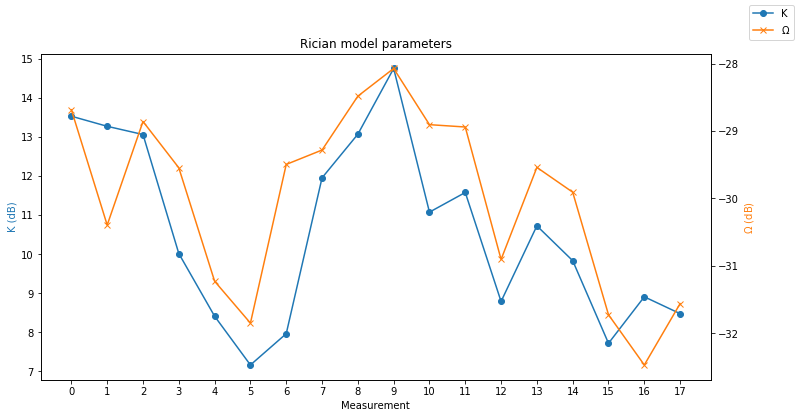

In [7]:
fig, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(10*np.log10(K), 'o-', label = 'K')
ax2 = ax1.twinx()
ax2.plot(10*np.log10(Omega), 'x-', color = 'C1', label = '$\Omega$')
fig.legend()
plt.title('Rician model parameters')
ax1.set_ylabel('K (dB)', color = 'C0')
ax2.set_ylabel('$\Omega$ (dB)', color = 'C1')
ax1.set_xlabel('Measurement')
ax1.set_xticks(np.arange(K.size));

In [8]:
def plot_correlation(x, noncoherent = False, span = 1000):
    if noncoherent:
        x = np.abs(x)
    x = x - np.average(x)
    corr = scipy.signal.correlate(x, x, mode = 'full')
    corr /= scipy.signal.correlate(np.ones(x.size), np.ones(x.size), mode = 'full')
    corr /= np.max(np.abs(corr[corr.size//2-span:corr.size//2+span]))
    t = np.arange(-span, span)*1e-3
    plt.plot(t, np.abs(corr[corr.size//2-span:corr.size//2+span]))

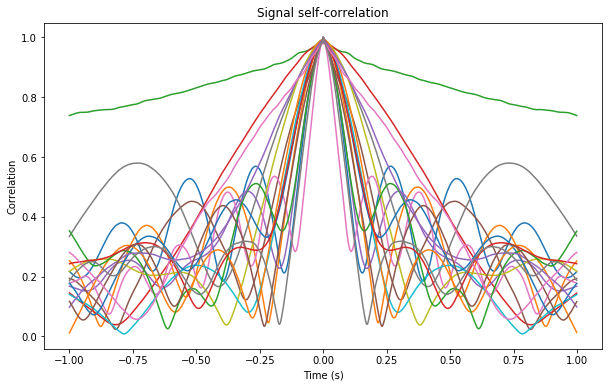

In [9]:
plt.figure(figsize = (10,6), facecolor = 'w')
for w in tone_windows:
    plot_correlation(x[(w[0] + 1) * avg : (w[1] - 1) * avg])
plt.title('Signal self-correlation')
plt.xlabel('Time (s)')
plt.ylabel('Correlation');

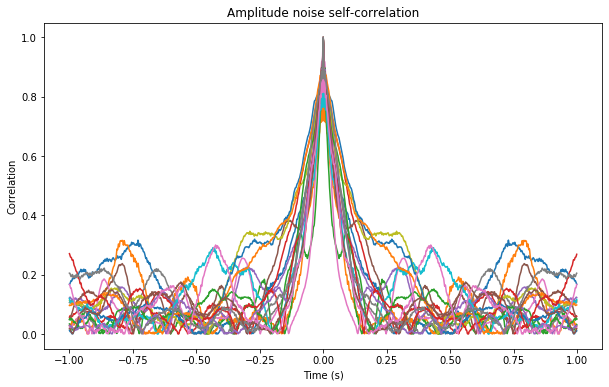

In [10]:
plt.figure(figsize = (10,6), facecolor = 'w')
for w in tone_windows:
    plot_correlation(x[(w[0] + 1) * avg : (w[1] - 1) * avg], noncoherent = True, span = 1000)
plt.title('Amplitude noise self-correlation')
plt.xlabel('Time (s)')
plt.ylabel('Correlation');

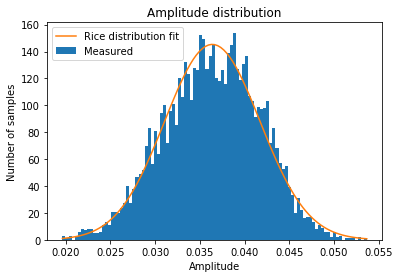

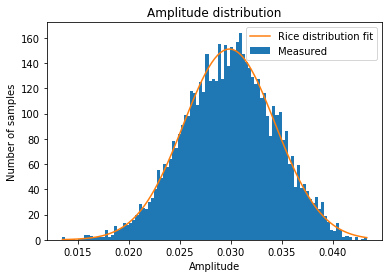

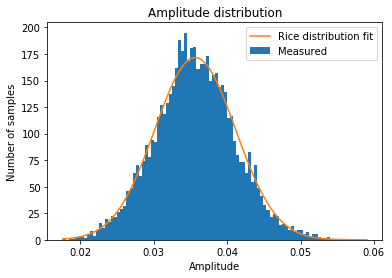

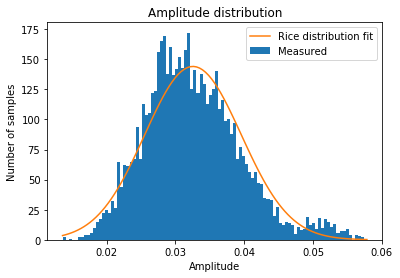

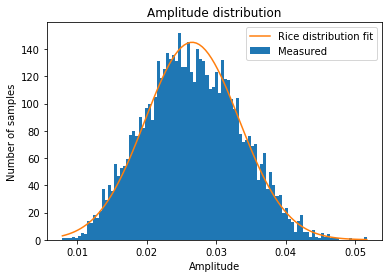

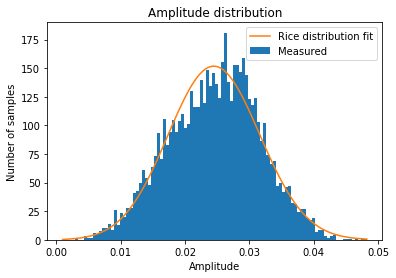

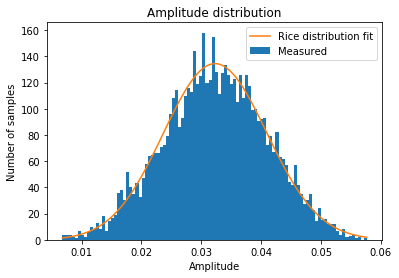

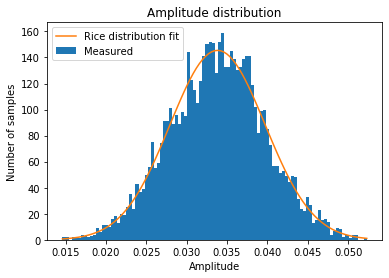

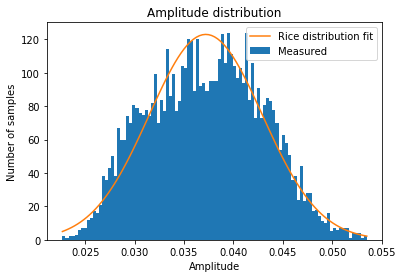

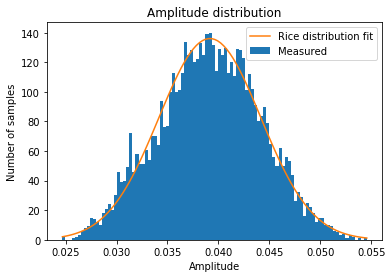

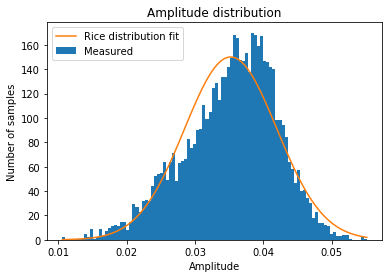

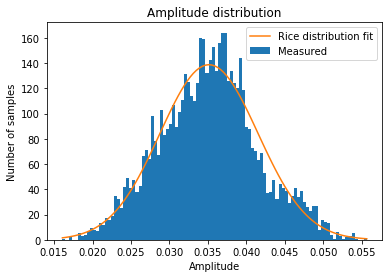

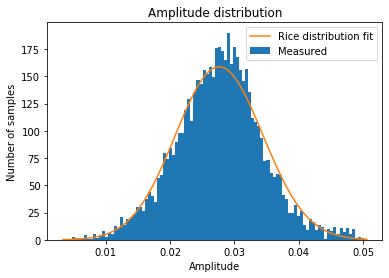

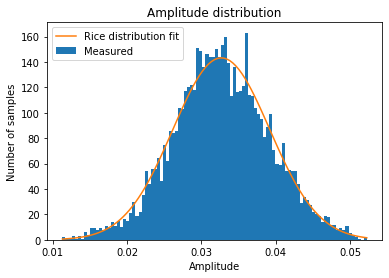

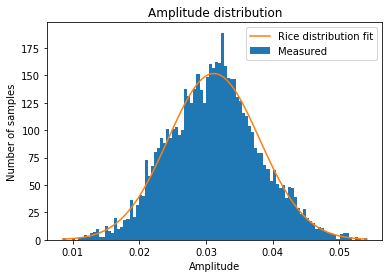

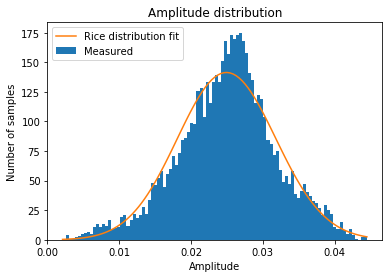

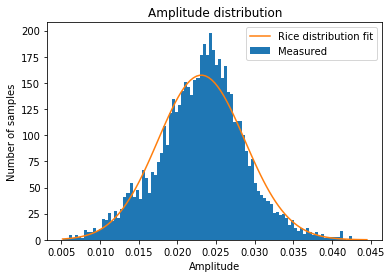

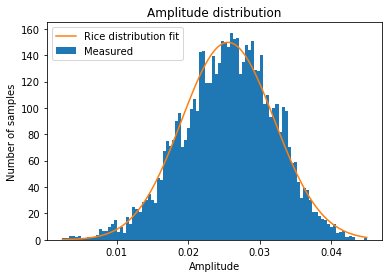

In [11]:
for sig in [x[(w[0] + 1) * avg : (w[1] - 1) * avg] for w in tone_windows]:
    plt.figure()
    bins = plt.hist(np.abs(sig), bins = 100)[1]
    tone_parameters = estimate_rice(np.abs(sig))
    K = 0.5*tone_parameters[0]**2/tone_parameters[1]**2
    Omega = tone_parameters[0]**2 + 2*tone_parameters[1]**2
    pdf = scipy.stats.rice.pdf(bins, tone_parameters[0]/tone_parameters[1], scale = tone_parameters[1])
    pdf *= sig.size / np.sum(pdf)
    plt.plot(bins, pdf)
    plt.title('Amplitude distribution')
    plt.legend(['Rice distribution fit', 'Measured'])
    plt.xlabel('Amplitude')
    plt.ylabel('Number of samples')

In [12]:
def plot_spectrum(x, N = 1024):
    w = np.hanning(N)
    fspan = 50*N//1024
    f_even = np.abs(np.fft.fftshift(np.fft.fft(x[:x.size//N*N].reshape((-1,N)) * w), axes = 1)[:,N//2-fspan:N//2+fspan])**2
    f_odd = np.abs(np.fft.fftshift(np.fft.fft(x[N//2:x.size//N*N-N//2].reshape((-1,N)) * w), axes = 1)[:,N//2-fspan:N//2+fspan])**2
    f = np.zeros((f_even.shape[0] + f_odd.shape[0], f_even.shape[1]))
    f[::2,:] = f_even
    f[1::2,:] = f_odd
    plt.figure(figsize = (12,8), facecolor = 'w')
    plt.imshow(np.log10(f).T, extent = (0, f.shape[0]*N//2*1e-3, -fspan*1e3/N, fspan*1e3/N), aspect = 'auto', origin = 'bottom', vmin = -3, vmax = 2.5, interpolation = 'lanczos')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Spectrum of beacon tones')
    return f

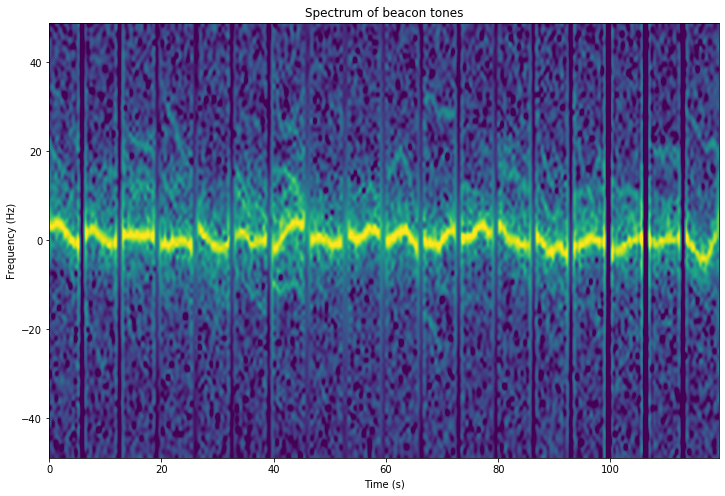

In [13]:
all_tones = np.concatenate([np.concatenate((x[(w[0] + 1) * avg : (w[1] - 1) * avg], np.zeros(1000))) for w in tone_windows])
plot_spectrum(all_tones);

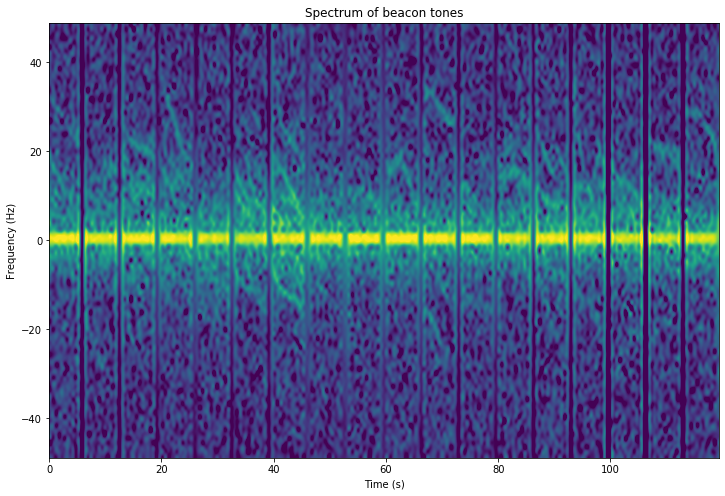

In [14]:
x_pll = np.fromfile('ed4yae_pll.c64', dtype = 'complex64')
all_tones_pll = np.concatenate([np.concatenate((x_pll[(w[0] + 1) * avg : (w[1] - 1) * avg], np.zeros(1000))) for w in tone_windows])
f = plot_spectrum(all_tones_pll, N = 1024)

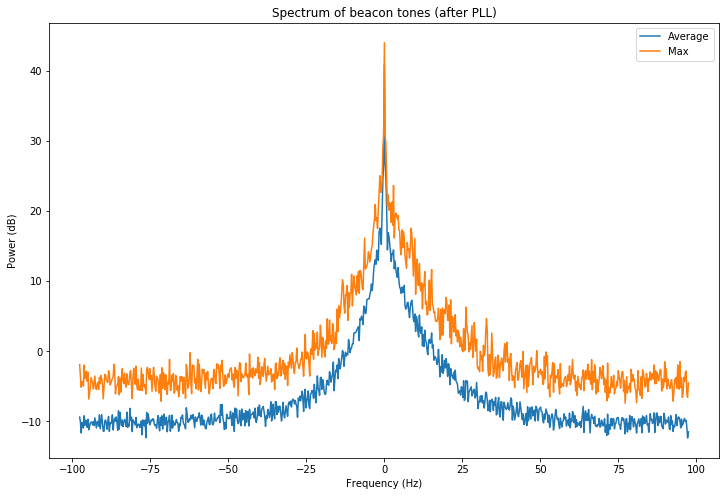

In [15]:
N = 4096
plt.figure(figsize = (12,8))
f = np.abs(np.fft.fftshift(np.fft.fft(all_tones_pll[:all_tones_pll.size//N*N].reshape((-1,N))))[:,N//2-400:N//2+400])**2
plt.plot(np.arange(-400,400)*1e3/N, 10*np.log10(np.average(f, axis = 0)))
plt.plot(np.arange(-400,400)*1e3/N, 10*np.log10(np.max(f, axis = 0)))
plt.legend(['Average', 'Max'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Spectrum of beacon tones (after PLL)');